### Excercise: use autoencoder (LSTM) for anomaly detection in accelerometer based vibration dataset.

####  The autoencoder tries to reconstruct the input at the output. Hence, for healthy data, it tries to reconstruct healthy data. But it will have a hard time trying to reconstruct faulty data in its neural network bottleneck (LSTM). That's how the anomaly detector works.

#### Download healthy and faulty dataframes from IBM cloud

In [ ]:
# !pip install tensorflow==2.5.0

In [1]:
# In order to obtain the correct values for "credentias", "bucket_name" and "endpoint" 
# please follow the tutorial at https://github.com/IBM/skillsnetwork/wiki/Cloud-Object-Storage-Setup

credentials = {
  "apikey": "RHPLuwaEctTZ68Ne8FwoHZaXKujcdzApQEgCauExsIbC",
  "cos_hmac_keys": {
    "access_key_id": "a89357bb879e4a59aa015abffb144827",
    "secret_access_key": "0d78e16cbb6fe96d6f3b55dca4c7f9b6d03ece26626b1cc3"
  },
  "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
  "iam_apikey_description": "Auto-generated for key a89357bb-879e-4a59-aa01-5abffb144827",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/3dba62a148ab4574867f8eb140c3a44e::serviceid:ServiceId-109769b1-d4d5-4997-93a1-faefc036bfa9",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/3dba62a148ab4574867f8eb140c3a44e:643e3143-6265-453a-877a-15ae3947ef9a::"
}

bucket_name = "cloud-object-storage-appliedaideeplearning"
endpoint = "https://s3.eu-de.cloud-object-storage.appdomain.cloud"

In [2]:
import base64
from ibm_botocore.client import Config
import ibm_boto3
import time

# Create client 
client = ibm_boto3.client(
    's3',
    aws_access_key_id = credentials["cos_hmac_keys"]['access_key_id'],
    aws_secret_access_key = credentials["cos_hmac_keys"]["secret_access_key"],
    endpoint_url=endpoint
)

client.download_file(bucket_name,'result_healthy_pandas.csv', 'result_healthy_pandas.csv')
client.download_file(bucket_name,'result_faulty_pandas.csv', 'result_faulty_pandas.csv')

In [5]:
import pandas as pd

df_healthy = pd.read_csv('result_healthy_pandas.csv', engine='python', header=None)
print(df_healthy.shape)
df_healthy.head()

(1213484, 4)


,0,1,2,3
0,0,100,0.014603,0.192922
1,1,100,0.054449,0.164364
2,2,100,0.107646,0.090811
3,3,100,0.133722,0.086496
4,4,100,0.112652,0.099235


In [4]:
df_healthy.loc[df_healthy[1] == 100]

,0,1,2,3
0,0,100,0.014603,0.192922
1,1,100,0.054449,0.164364
2,2,100,0.107646,0.090811
3,3,100,0.133722,0.086496
4,4,100,0.112652,0.099235
...,...,...,...,...
485638,485638,100,0.035673,0.125122
485639,485639,100,-0.004590,0.124916
485640,485640,100,-0.023574,0.109302
485641,485641,100,0.005215,0.052185


In [6]:
df_faulty = pd.read_csv('result_faulty_pandas.csv', engine='python', header=None)
print(df_faulty.shape)
df_faulty.head()

(488309, 4)


,0,1,2,3
0,0,106,-0.277602,0.040885
1,1,106,-0.044345,0.069855
2,2,106,0.117603,0.337767
3,3,106,-0.145055,0.251682
4,4,106,-0.111430,0.108891


#### Import necessary libraries

In [9]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

%matplotlib inline

#### Plot data samples

In [10]:
def get_recording(df, file_id):
    return np.array(df.sort_values(by=0, ascending=True).loc[df[1] == file_id].drop(0,1).drop(1,1))


In [12]:
healthy_sample = get_recording(df_healthy,100)
faulty_sample = get_recording(df_faulty,105)

print(healthy_sample.shape, faulty_sample.shape)

(485643, 2) (121265, 2)


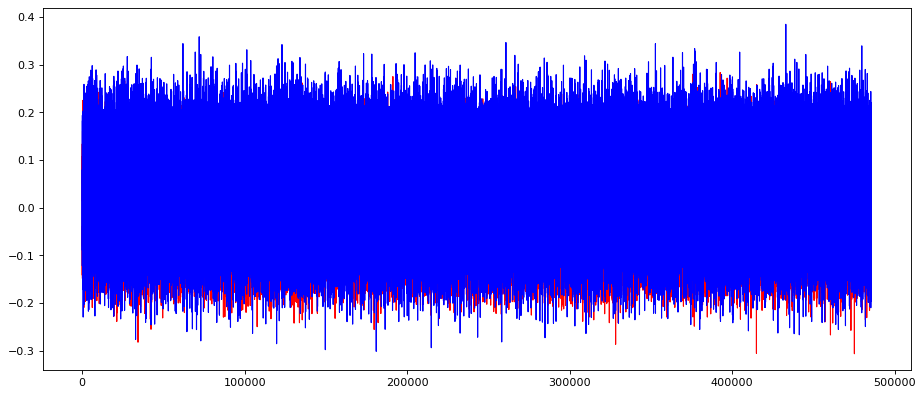

In [13]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_sample)
ax.plot(range(0,size), healthy_sample[:,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), healthy_sample[:,1], '-', color='blue', animated = True, linewidth=1)

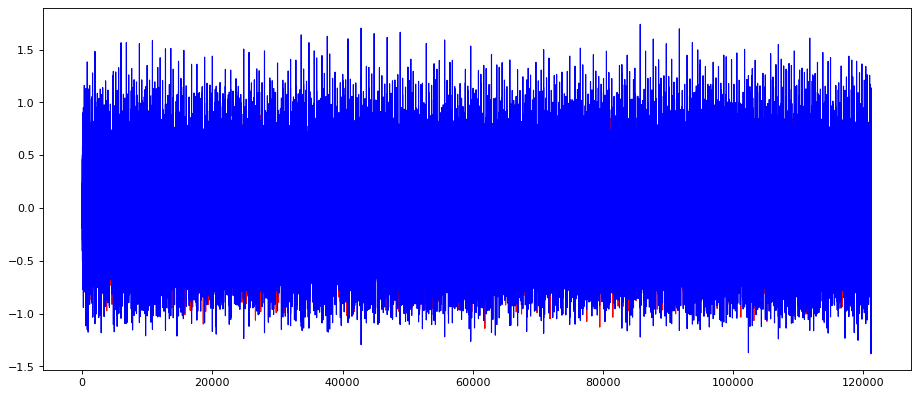

In [14]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(faulty_sample)
ax.plot(range(0,size), faulty_sample[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), faulty_sample[:,0], '-', color='blue', animated = True, linewidth=1)

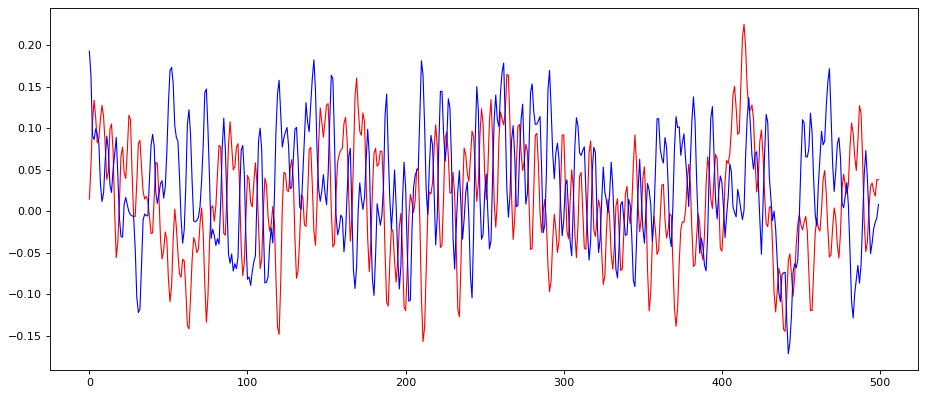

In [15]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,500), healthy_sample[:500,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,500), healthy_sample[:500,1], '-', color='blue', animated = True, linewidth=1)

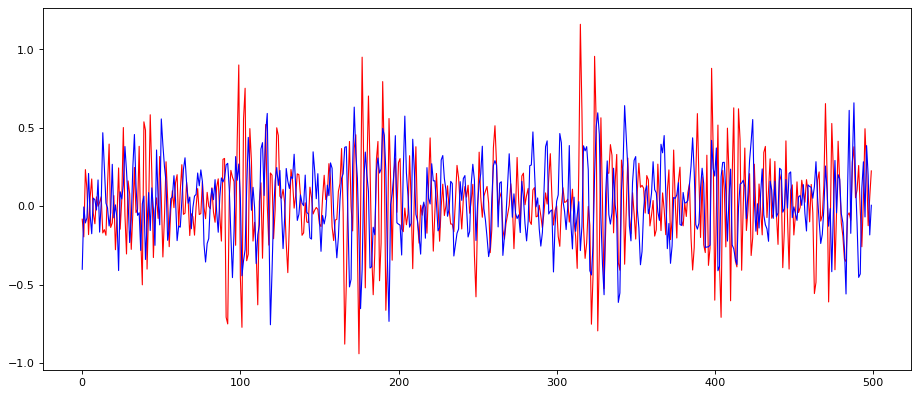

In [16]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,500), faulty_sample[:500,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,500), faulty_sample[:500,1], '-', color='blue', animated = True, linewidth=1)

#### Define and compile autoencoder model

In [17]:
# callback handler, which is called by keras, on the beginning of every training epoch, to record a trajectory of losses during training.
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [18]:
timesteps = 100 # we are using 100 past samples to predict 100 future samples
dim = 2 # two accelerometer sensor readings per instance
lossHistory = LossHistory()
# design network

model = Sequential()
model.add(LSTM(50, input_shape=(timesteps, dim), return_sequences=True))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')

def train(data):
    # we pass data twice, as input and output; this is how an autoencoder works.
    model.fit(data, data, epochs=20, batch_size=72, validation_data=(data, data), verbose=1, shuffle=False, callbacks=[lossHistory])

def score(data):
    yhat =  model.predict(data)
    return yhat

In [ ]:
# #some learners constantly reported 502 errors in Watson Studio. 
# #This is due to the limited resources in the free tier and the heavy resource consumption of Keras.
# #This is a workaround to limit resource consumption

# import os
# # reduce number of threads
# os.environ['TF_NUM_INTEROP_THREADS'] = '1'
# os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
# import tensorflow

#### Function to create trimmed recordings on which the autoencoder will be trained

In [40]:
def create_trimmed_recording(df, file_id):
    recording = get_recording(df, file_id)
#     print(recording.shape)
    samples = len(recording)
    trim = samples % 100
    recording_trimmed = recording[:samples-trim]
#     print(recording_trimmed.shape)
    recording_trimmed.shape = (int((samples-trim)/timesteps), timesteps, dim) # reshape recording array, so it's subdivided in windows of length 'timesteps'. 
#     print(recording_trimmed.shape)
    return recording_trimmed


In [39]:
rec = create_trimmed_recording(df_healthy, 100)
print(rec.shape)

(485643, 2)
(485600, 2)
(4856, 100, 2)
(4856, 100, 2)


In [35]:
print(rec[0,:5,:])
print(rec[1,:5,:])

[[0.01460308 0.19292182]
 [0.05444862 0.16436364]
 [0.10764554 0.09081091]
 [0.13372246 0.08649636]
 [0.11265231 0.09923455]]
[[ 0.04318338 -0.08197636]
 [ 0.037968   -0.07930545]
 [ 0.01043077 -0.08937273]
 [ 0.00521538 -0.07293636]
 [ 0.03400431 -0.06102   ]]


#### Train the autoencoder on healthy data

In [20]:
#pd.unique()
#df_healthy.drop(0,1).drop(2,1).drop(3,1)
pd.unique(df_healthy.iloc[:,1])

array([100,  98,  97])

In [41]:
file_ids = pd.unique(df_healthy.iloc[:,1])
start = time.time()
for file_id in file_ids:
    recording_trimmed = create_trimmed_recording(df_healthy, file_id)
    print("Starting training on %s" % (file_id))
    train(recording_trimmed)
    print("Finished training on %s after %s seconds" % (file_id, time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
healthy_losses = lossHistory.losses


Starting training on 100
Epoch 1/20
68/68 [==============================] - 4s 56ms/step - loss: 0.0403 - val_loss: 0.0309
Epoch 2/20
68/68 [==============================] - 4s 52ms/step - loss: 0.0192 - val_loss: 0.0094
Epoch 3/20
68/68 [==============================] - 3s 49ms/step - loss: 0.0101 - val_loss: 0.0081
Epoch 4/20
68/68 [==============================] - 3s 50ms/step - loss: 0.0061 - val_loss: 0.0041
Epoch 5/20
68/68 [==============================] - 4s 52ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 6/20
68/68 [==============================] - 4s 54ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 7/20
68/68 [==============================] - 4s 52ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 8/20
68/68 [==============================] - 4s 52ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 9/20
68/68 [==============================] - 4s 51ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/20
68/68 [==============================] - 4s 52ms/step - loss: 0.0013 - v

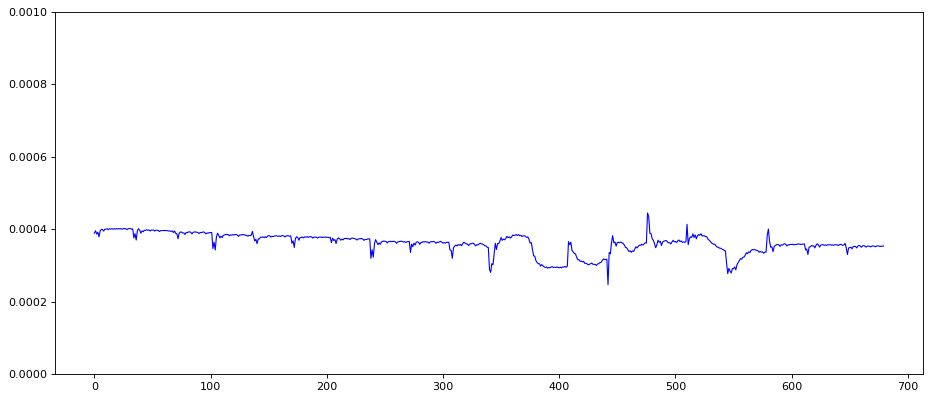

In [44]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses)
plt.ylim(0,0.001)
ax.plot(range(0,size), healthy_losses, '-', color='blue', animated = True, linewidth=1)

In [53]:
#file_ids = spark.sql('select distinct _c1 from df_healhty').rdd.map(lambda row : row._c1).collect()
start = time.time()
for file_id in [105]:
    recording_trimmed = create_trimmed_recording(df_faulty,file_id)
    print("Staring training on %s" % (file_id))
    train(recording_trimmed)
    print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
faulty_losses_105 = lossHistory.losses

Staring training on 105
Epoch 1/20
17/17 [==============================] - 1s 51ms/step - loss: 4.6997e-04 - val_loss: 4.8841e-04
Epoch 2/20
17/17 [==============================] - 1s 51ms/step - loss: 4.7126e-04 - val_loss: 4.0056e-04
Epoch 3/20
17/17 [==============================] - 1s 51ms/step - loss: 4.5619e-04 - val_loss: 4.7709e-04
Epoch 4/20
17/17 [==============================] - 1s 51ms/step - loss: 4.0518e-04 - val_loss: 3.6581e-04
Epoch 5/20
17/17 [==============================] - 1s 51ms/step - loss: 3.8084e-04 - val_loss: 4.0338e-04
Epoch 6/20
17/17 [==============================] - 1s 51ms/step - loss: 3.9026e-04 - val_loss: 3.5627e-04
Epoch 7/20
17/17 [==============================] - 1s 53ms/step - loss: 3.7706e-04 - val_loss: 3.9738e-04
Epoch 8/20
17/17 [==============================] - 1s 51ms/step - loss: 3.7552e-04 - val_loss: 3.5506e-04
Epoch 9/20
17/17 [==============================] - 1s 51ms/step - loss: 3.8085e-04 - val_loss: 4.0314e-04
Epoch 10/20
1

In [42]:
pd.unique(df_faulty.iloc[:,1])

array([106, 107, 108, 105])

In [52]:
file_ids = pd.unique(df_faulty.iloc[:,1])
start = time.time()
for file_id in file_ids:
    recording_trimmed = create_trimmed_recording(df_faulty,file_id)
    print("Staring training on %s" % (file_id))
    train(recording_trimmed)
    print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
faulty_losses = lossHistory.losses

Staring training on 106
Epoch 1/20
17/17 [==============================] - 1s 52ms/step - loss: 5.8560e-04 - val_loss: 6.6935e-04
Epoch 2/20
17/17 [==============================] - 1s 53ms/step - loss: 5.7730e-04 - val_loss: 5.0477e-04
Epoch 3/20
17/17 [==============================] - 1s 52ms/step - loss: 5.7422e-04 - val_loss: 6.0907e-04
Epoch 4/20
17/17 [==============================] - 1s 51ms/step - loss: 6.0721e-04 - val_loss: 6.7012e-04
Epoch 5/20
17/17 [==============================] - 1s 55ms/step - loss: 6.0123e-04 - val_loss: 5.8644e-04
Epoch 6/20
17/17 [==============================] - 1s 60ms/step - loss: 5.8250e-04 - val_loss: 6.4113e-04
Epoch 7/20
17/17 [==============================] - 1s 52ms/step - loss: 5.7984e-04 - val_loss: 5.2625e-04
Epoch 8/20
17/17 [==============================] - 1s 55ms/step - loss: 5.6167e-04 - val_loss: 6.4782e-04
Epoch 9/20
17/17 [==============================] - 1s 52ms/step - loss: 5.6041e-04 - val_loss: 5.8334e-04
Epoch 10/20
1

#### We append faulty to healthy losses to better identify anomaly

In [59]:
print(len(healthy_losses))
print(len(faulty_losses_105))
print(len(faulty_losses))

680
340
340


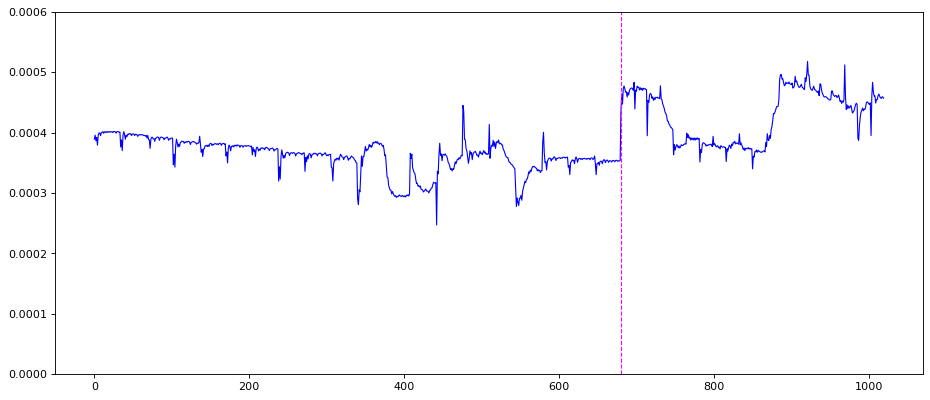

In [67]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses+faulty_losses_105)
plt.ylim(0,0.0006)
ax.plot(range(0,size), healthy_losses+faulty_losses_105, '-', color='blue', animated = True, linewidth=1)
ax.axvline(x=len(healthy_losses), c='magenta', ls='--', lw=1)

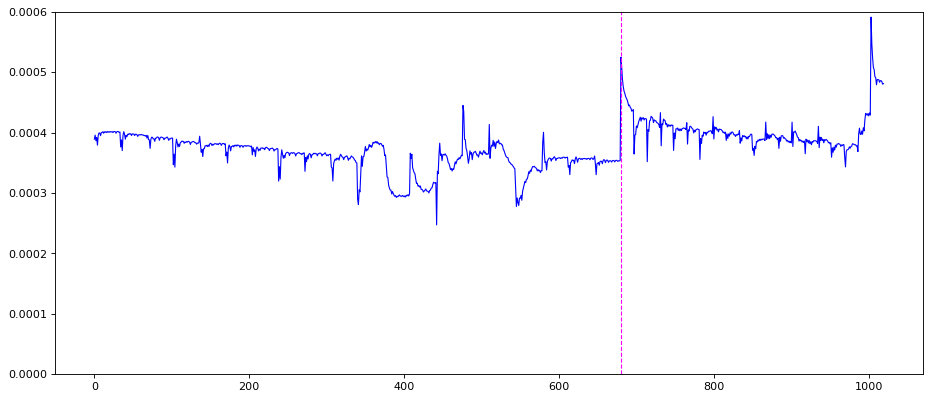

In [68]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses+faulty_losses)
plt.ylim(0,0.0006)
ax.plot(range(0,size), healthy_losses+faulty_losses, '-', color='blue', animated = True, linewidth=1)
ax.axvline(x=len(healthy_losses), c='magenta', ls='--', lw=1)